## Imports
---

In [5]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime
from src.heikin_ashi import heikin_ashi
from src.indicators import supertrend, VWAP2, smc
import pandas_ta as ta

## Getting the Data
---

## Polygon API
---

In [22]:

def cog(source, length):
    sum = source.rolling(length, min_periods=1).sum()
    num = 0
    for i in range(length):
        price = source.shift(i).fillna(0)
        num += price * (i + 1)
    return -(num / sum).replace([np.inf, -np.inf], np.nan).fillna(0)

def normalizeDeriv(src, quadraticMeanLength):
    derivative = src - src.shift(2)  # Calculate the derivative
    quadraticMean = np.sqrt(np.nan_to_num(np.sum(np.power(derivative, 2)) / quadraticMeanLength, nan=0))
    normalizedDeriv = derivative / quadraticMean  # Calculate normalized derivative
    series = pd.Series(index=src.index, data=normalizedDeriv*100)
    return series

def tanh(_src):
    vals = -1 + 2/(1 + np.exp(-2*_src))
    series = pd.Series(index=_src.index, data=vals)
    return series

def dualPoleFilter(_src, _lookback):
    _omega = -99 * math.pi / (70 * _lookback)
    _alpha = np.exp(_omega)
    _beta = -np.power(_alpha, 2)
    _gamma = np.cos(_omega) * 2 * _alpha
    _delta = 1 - _gamma - _beta
    _slidingAvg = 0.5 * (_src + np.nan_to_num(_src.shift(1), nan=_src[0]))
    _filter = np.empty_like(_src)
    _filter[0] = np.nan
    
    for i in range(1, len(_src)):
        _filter[i] = (_delta * _slidingAvg[i]) + _gamma * np.nan_to_num(_filter[i-1], nan=0) + _beta * np.nan_to_num(_filter[i-2], nan=0)
    series = pd.Series(_filter, index=_src.index)
    return series

def getOscillator(data, smoothingFrequency=50, quadraticMeanLength=50):
    nDeriv = normalizeDeriv(data, quadraticMeanLength)
    hyperbolicTangent = tanh(nDeriv)
    result = dualPoleFilter(hyperbolicTangent, smoothingFrequency)
    return result

s_length = 1.75

hourly = forex_data.resample('1H').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'})
signalSlow = getOscillator(forex_data["Close"])
seriesSlow = s_length*signalSlow
seriesSlowMirror = -seriesSlow




In [25]:
len(seriesSlow)

238830

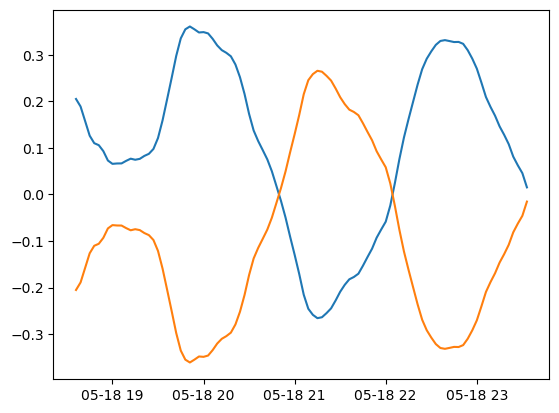

In [29]:

plt.plot(seriesSlow[238300:238400])
plt.plot(seriesSlowMirror[238300:238400])


In [174]:
print(dualPoleFilter(forex_data["Close"], 50)[230000:230030])

timestamp
2023-04-25 17:03:00    1.096889
2023-04-25 17:06:00    1.096880
2023-04-25 17:09:00    1.096874
2023-04-25 17:12:00    1.096869
2023-04-25 17:15:00    1.096859
2023-04-25 17:18:00    1.096848
2023-04-25 17:21:00    1.096834
2023-04-25 17:24:00    1.096818
2023-04-25 17:27:00    1.096805
2023-04-25 17:30:00    1.096792
2023-04-25 17:33:00    1.096781
2023-04-25 17:36:00    1.096772
2023-04-25 17:39:00    1.096761
2023-04-25 17:42:00    1.096750
2023-04-25 17:45:00    1.096739
2023-04-25 17:48:00    1.096726
2023-04-25 17:51:00    1.096716
2023-04-25 17:54:00    1.096712
2023-04-25 17:57:00    1.096711
2023-04-25 18:00:00    1.096714
2023-04-25 18:03:00    1.096720
2023-04-25 18:06:00    1.096729
2023-04-25 18:09:00    1.096739
2023-04-25 18:12:00    1.096752
2023-04-25 18:15:00    1.096767
2023-04-25 18:18:00    1.096783
2023-04-25 18:21:00    1.096798
2023-04-25 18:24:00    1.096813
2023-04-25 18:27:00    1.096831
2023-04-25 18:30:00    1.096851
dtype: float64


In [117]:
print(cog(forex_data["Close"], 6)[:10])

timestamp
2021-06-20 19:00:00        -inf
2021-06-20 19:09:00        -inf
2021-06-20 19:36:00        -inf
2021-06-20 19:42:00        -inf
2021-06-20 19:45:00        -inf
2021-06-20 19:51:00   -3.500183
2021-06-20 19:54:00   -3.499964
2021-06-20 20:00:00   -3.499968
2021-06-20 20:03:00   -3.500005
2021-06-20 20:06:00   -3.500005
dtype: float64


In [157]:
#import modules
from polygon import RESTClient
import datetime as dt

polygonAPIkey = 'n5WUioGpm5YNuvJ0Bfn_No8nQHdfn_eP'
client = RESTClient(api_key=polygonAPIkey)

def getData(ticker, timespan, start, end):
    bars = client.get_aggs(ticker=ticker, multiplier=3, timespan=timespan, from_=start, to=end)
    print(len(bars))


    #list of polygon OptionsContract objects to DataFrame
    downloadedData = pd.DataFrame(bars)

    #create Date column
    downloadedData['Date'] = pd.to_datetime(downloadedData['timestamp'], unit='ms')
    downloadedData['Date'] = pd.to_datetime(downloadedData['Date'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S')))
    downloadedData.set_index('Date', inplace=True)

    #drop unnecessary columns
    downloadedData = downloadedData.drop(['vwap', 'transactions', 'otc'], axis=1)
    downloadedData = downloadedData.rename(columns={"open": "Open", "high": "High", "low": "Low", "close": "Close", "volume": "Volume"})

    return downloadedData


In [ ]:
import os
import pandas as pd
import datetime as dt
import time
from polygon import RESTClient

polygonAPIkey = 'n5WUioGpm5YNuvJ0Bfn_No8nQHdfn_eP'
client = RESTClient(api_key=polygonAPIkey)

def downloadAllData(ticker, timespan, start, end, csv_directory):
    current_start = start
    cumulative_data = pd.DataFrame()

    while current_start < end:
        current_end = min(current_start + pd.DateOffset(days=3), end)
        data = getData(ticker, timespan, current_start, current_end)

        if not data.empty:
            # Create directory if it doesn't exist
            os.makedirs(csv_directory, exist_ok=True)

            # Save data for the current day
            csv_file = os.path.join(csv_directory, f"{current_start.strftime('%Y-%m-%d')}.csv")
            data.to_csv(csv_file)

            # Append data to cumulative dataframe
            cumulative_data = pd.concat([cumulative_data, data])

            print(f"Downloaded data for {current_start} to {current_end}")

        current_start = current_end + pd.DateOffset(days=0)
        time.sleep(61)

    # Save cumulative data to a cumulative CSV file
    cumulative_csv_file = os.path.join(csv_directory, "cumulative_data.csv")
    cumulative_data.to_csv(cumulative_csv_file)

    return cumulative_data

# Example usage
end_date = dt.datetime.now().date()
start_date = end_date - dt.timedelta(days=700)
csv_directory = "data_directory"

data = downloadAllData("C:EURUSD", "minute", start_date, end_date, csv_directory)
print(data.head())
print(data.tail())

## The Strategy
---

In [11]:
forex_data = pd.read_csv("./data_directory/cumulative_data.csv")
forex_data['timestamp'] = pd.to_datetime(forex_data['timestamp'], unit='ms')
forex_data['timestamp'] = pd.to_datetime(forex_data['timestamp'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S')))
forex_data.set_index('timestamp', inplace=True)
forex_data.drop_duplicates(inplace=True)


In [9]:
!pip install ta-lib

  Using cached TA-Lib-0.4.26.tar.gz (272 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ta-lib: filename=TA_Lib-0.4.26-cp38-cp38-macosx_11_0_arm64.whl size=394242 sha256=e93ffac2f1230216f96ecb79c6c0b5a281c029b1876a97c690efef31333e2dcc
  Stored in directory: /Users/dennisschielke/Library/Caches/pip/wheels/00/67/df/e4086b47c1dc8e0a75fd54840d206f8a90bb86eb718e2cdd4d
Successfully built ta-lib


In [ ]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import talib as tab

class PIES(Strategy):
    
    def init(self):
        # Store orderblock values
        self.orderblocksU = []
        self.orderblocksB = []
        # If orderblock got hit and price is above/below upperbands/lowerbands
        self.tagged = False
        self.taggedprice = 0
        self.taggeddev = 0
        # Counter of how many candles it was ago when orderblock got tagged
        self.taggedcounter = 0
        # Overall candle count
        self.candlecount = 17
        self.trade_opened = False
        self.stoploss = 0
        self.sholong = 0  #0 stands for long trade and 1 for short trade
        # Values that act as a buffer for the orderblocks after they got hit
        self.orderblocklow = 0
        self.orderblockhigh = 0
        
        # Supertrend Indicator
        self.supertrendu = self.I(supertrend, self.data.df, lookback=10, multiplier=2.5, band=0)
        self.supertrendl = self.I(supertrend, self.data.df, lookback=10, multiplier=2.5, band=1)
        # VWAP Indicator
        self.vwap = self.I(VWAP2, self.data.df, 0)
        self.vwapu1 = self.I(VWAP2, self.data.df, 1)
        self.vwapl1 = self.I(VWAP2, self.data.df, 2)
        self.vwapu2 = self.I(VWAP2, self.data.df, 3)
        self.vwapl2 = self.I(VWAP2, self.data.df, 4)
        self.vwapu3 = self.I(VWAP2, self.data.df, 5)
        self.vwapl3 = self.I(VWAP2, self.data.df, 6)
        # Orderblock Indicator
        self.upperOB = self.I(smc, self.data.df, length=10, band=1)
        self.lowerOB = self.I(smc, self.data.df, length=10, band=0)
        # ATR Indicator
        self.atr = self.I(tab.ATR, self.data.High, self.data.Low, self.data.Close, 14)

    def next(self):
        # Add orderblocks

        if(self.upperOB[-1] > 0):
            self.orderblocksU.append([self.data.High[-1], self.data.Low[-1], self.candlecount])
        if(self.lowerOB[-1] > 0):
            self.orderblocksB.append([self.data.High[-1], self.data.Low[-1], self.candlecount])
        # If no trade is open
        if not self.trade_opened and self.data.index[-1].hour > 6 and self.data.index[-1].hour < 12:
            # If it didnt hit orderblock + upper/lower band yet
            if self.tagged==False:
                # For loops to iterate through the orderblocks and check if they got hit
                for high, low, candle in self.orderblocksU:
                    if self.data.High[-1] > low and self.data.High[-1] < high and self.candlecount - candle < 1000 and ((self.data.High[-1] > self.vwapu2[-1] - (self.atr[-1]/2) and self.data.High[-1] < self.vwapu2[-1] + (self.atr[-1]/2)) or (self.data.High[-1] > self.vwapu3[-1] - (self.atr[-1]/2) and self.data.High[-1] < self.vwapu3[-1] + (self.atr[-1]/2))):
                        self.tagged = True
                        if(self.data.High[-1] < self.vwapu2[-1] + (self.atr[-1]/2)):
                            self.taggeddev = 2
                        else:
                            self.taggeddev = 3
                        self.taggedprice = self.data.High[-1]
                        self.orderblocklow = low
                        self.sholong = 1
                        self.orderblocksU.remove([high, low, candle])
                        break
                for high, low, candle in self.orderblocksB:
                    if self.data.Low[-1] < high and self.data.Low[-1] > low and self.candlecount - candle < 1000 and ((self.data.Low[-1] < self.vwapl2[-1] + (self.atr[-1]/2) and self.data.Low[-1] > self.vwapl2[-1] - (self.atr[-1]/2)) or (self.data.Low[-1] < self.vwapl3[-1] + (self.atr[-1]/2) and self.data.Low[-1] > self.vwapl3[-1] - (self.atr[-1]/2))):
                        self.tagged = True
                        if(self.data.Low[-1] > self.vwapl2[-1] - (self.atr[-1]/2)):
                            self.taggeddev = 2
                        else:
                            self.taggeddev = 3
                        self.orderblockhigh = high
                        self.sholong = 0
                        self.orderblocksB.remove([high, low, candle])
                        break

            # If it hit and we have to go short

            elif (self.tagged == True and self.sholong == 1):
                # Heikin Ashi Candles)
                ha_close = 1/4*(self.data.Open[-1] + self.data.Close[-1] + self.data.High[-1] + self.data.Low[-1])
                ha_open = 1/2*(self.data.Open[-2] + self.data.Close[-2])
                ha_high = max(self.data.High[-1], ha_open, ha_close)
                ha_low = min(self.data.Low[-1], ha_open, ha_close)
                if((self.data.High[-1] > self.vwapu2[-1] + (self.atr[-1]/2) and self.taggeddev == 2) or (self.data.High[-1] > self.vwapu3[-1] + (self.atr[-1]/2) and self.taggeddev == 3)):
                    self.tagged = False
                else:
                    if self.taggedcounter < 7:
                        if self.data.High[-1] < self.orderblocklow and ha_open > (ha_high - ((ha_high - ha_low)*0.12) and self.data.Close[-1]>self.vwapu1[-1]):
                            self.trade_opened = True
                            self.stoploss = 0
                            for i in range(1, 10):
                                if self.data.High[-i] > self.stoploss:
                                    self.stoploss = self.data.High[-i]
                            def berechnen(kapital, stoploss, entry):
                                    diff = stoploss - entry
                                    size = abs((kapital/10000) / diff)
                                    return int(round(size,0))
                            sizeO = berechnen(self.equity, self.stoploss, self.data.Close[-1])
                            try:
                                self.sell(size=sizeO)
                            except:
                                print("Something went wrong")
                        self.taggedcounter += 1
                    else: 
                        self.tagged = False
                        self.taggedcounter = 0
            # If it hit and we have to go long
            elif (self.tagged == True and self.sholong == 0):
                # Heikin Ashi Candles
                ha_close = 1/4*(self.data.Open[-1] + self.data.Close[-1] + self.data.High[-1] + self.data.Low[-1])
                ha_open = 1/2*(self.data.Open[-2] + self.data.Close[-2])
                ha_high = max(self.data.High[-1], ha_open, ha_close)
                ha_low = min(self.data.Low[-1], ha_open, ha_close)
                if((self.data.Low[-1] < self.vwapl2[-1] - (self.atr[-1]/2) and self.taggeddev == 2) or (self.data.Low[-1] < self.vwapl3[-1] - (self.atr[-1]/2) and self.taggeddev == 3)):
                    self.tagged = False
                if self.taggedcounter < 7:
                    if self.data.Low[-1] > self.orderblockhigh and ha_open < (ha_low + (ha_high - ha_low) * 0.12) and self.data.Close[-1]<self.vwapl1[-1]:
                        self.stoploss = 100 # Set stoploss to high value
                        for i in range(1, 10):
                            if self.data.Low[-i] < self.stoploss:
                                self.stoploss = self.data.Low[-i]
                        def berechnen(kapital, stoploss, entry):
                            diff = stoploss - entry
                            size = abs((kapital/10000) / diff)
                            return int(round(size,0))
                        sizeO = berechnen(self.equity, self.stoploss, self.data.Close[-1])
                        try:
                            self.buy(size=sizeO)
                        except:
                            print("Something went wrong")
                        self.trade_opened = True
                    self.taggedcounter += 1
                else: 
                    self.tagged = False
                    self.taggedcounter = 0
        

        elif self.trade_opened: # Stop loss path
            if self.sholong == 0:
                if(self.supertrendl[-2] > 0 and self.supertrendu[-1] > 0) or self.data.Close[-1] < self.stoploss:
                    self.position.close()
                    self.trade_opened = False
                    self.tagged = False
            elif self.sholong == 1:
                if(self.supertrendu[-2] > 0 and self.supertrendl[-1] > 0) or self.data.Close[-1] > self.stoploss:
                    self.position.close()
                    self.trade_opened = False
                    self.tagged = False
        self.candlecount = self.candlecount + 1
        
bt2 = Backtest(forex_data[:100000], PIES, cash=10000000, commission=0.00, exclusive_orders=True)
# Run the backtest and append the results to the list
output2 = bt2.run()
# Print the results
print(output2)

bt2.plot(filename="./ChartPlots/PIES_20.05.23_0.html", plot_volume=False)

In [21]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

# Parameter für Philip

atr_window = 6
einsatz = 0.5 # Hier stehen Kommazahlen für den Prozentuallen Anteil deiner Equity die du setzen willst
# Oder du kannst auch ganze Zahlen nuzen für die Anzahl der Shares die du kaufen willst. Falls du alles reinsetzen
# Willst benutz 0.9999
satr = 3 # * atr in stoploss
tatr = 9 # * atr in take profit


class PIIL(Strategy):
    def init(self):
        self.trade_opened = False
        self.take_profit = 0
        self.sl = 0
        self.atr = self.I(tab.ATR, self.data.High, self.data.Low, self.data.Close, atr_window)

    def next(self):
        if not self.trade_opened and self.data.index[-1].hour == 5 and self.data.index[-1].minute == 0:
            self.buy(size=einsatz)
            self.sl = self.data.Close[-1] - satr * self.atr[-1]
            self.take_profit = self.data.Close[-1] + tatr * self.atr[-1]
            self.trade_opened = True

        elif self.trade_opened:
            if self.data.Close[-1] > self.take_profit or self.data.Close[-1] < self.sl:
                self.position.close()
                self.trade_opened = False
                self.take_profit = 0
                self.sl = 0


class PIIS(Strategy):
    def init(self):
        self.candlecount = 0
        self.trade_opened = False
        self.take_profit = 0
        self.sl = 0
        self.atr = self.I(tab.ATR, self.data.High, self.data.Low, self.data.Close, atr_window)

    def next(self):
        if not self.trade_opened and self.data.index[-1].hour == 5 and self.data.index[-1].minute == 0:
            self.sl = self.data.Close[-1] + satr*self.atr[-1]
            self.take_profit = self.data.Close[-1] - tatr*self.atr[-1]
            self.sell(size=einsatz)
            self.trade_opened = True

        elif self.trade_opened:
            if self.data.Close[-1] < self.take_profit or self.data.Close[-1] > self.sl:
                self.position.close()
                self.trade_opened = False
                self.take_profit = 0
                self.sl = 0



bt = Backtest(forex_data,PIIL, cash=1000000, commission=0.00, exclusive_orders=True)
bt2 = Backtest(forex_data,PIIS, cash=1000000, commission=0.00, exclusive_orders=True)

output = bt.run()
print(output)

output2 = bt2.run()
print(output2)


Start                     2021-06-20 19:00:00
End                       2023-05-19 21:03:00
Duration                    698 days 02:03:00
Exposure Time [%]                   17.742746
Equity Final [$]                 993237.06753
Equity Peak [$]                 1007818.72049
Return [%]                          -0.676293
Buy & Hold Return [%]               -8.775154
Return (Ann.) [%]                   -0.263955
Volatility (Ann.) [%]                1.456316
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -1.850184
Avg. Drawdown [%]                   -0.074406
Max. Drawdown Duration      485 days 02:06:00
Avg. Drawdown Duration        8 days 15:46:00
# Trades                                  484
Win Rate [%]                        26.033058
Best Trade [%]                       0.890181
Worst Trade [%]                     -0.677589
Avg. Trade [%]                    

In [31]:
bt2.plot()

/Users/dennisschielke/miniconda3/envs/pie/lib/python3.8/site-packages/backtesting/_plotting.py:122: UserWarning: Data contains too many candlesticks to plot; downsampling to '2H'. See `Backtest.plot(resample=...)`
  warnings.warn(f"Data contains too many candlesticks to plot; downsampling to {freq!r}. "
/Users/dennisschielke/miniconda3/envs/pie/lib/python3.8/site-packages/backtesting/_plotting.py:148: FutureWarning: Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  new_bar_idx = new_index.get_loc(mean_time, method='nearest')
/Users/dennisschielke/miniconda3/envs/pie/lib/python3.8/site-packages/backtesting/_plotting.py:148: FutureWarning: Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  new_bar_idx = new_index.get_loc(mean_time, method='nearest')
/Users/dennisschielke/miniconda3/envs/pie/lib/python3.8/site-pa

GridPlot(id='p2679', ...)